# Recommender Systems Course Final Project

## Download the data if needed

In [1]:
%%bash
if [ -d data_final_project ]; then
    echo "Data is already downloaded, skipping..."    
    exit 0
fi
wget -q --no-check-certificate 'https://drive.usercontent.google.com/download?id=1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE&export=download&confirm=t&uuid=b2002093-cc6e-4bd5-be47-9603f0b33470
' -O KuaiRec.zip
unzip KuaiRec.zip -d data_final_project

Data is already downloaded, skipping...


## Load & cleanup the data

In [ ]:
from dataclasses import dataclass
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession, DataFrameReader
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
spark = (
    SparkSession.builder
    .appName("ALSMatrixFactorisation")
    .config("spark.driver.memory", "32g")
    .config("spark.kryoserializer.buffer.max", "2047m")
    # Makes converting dataframes from pandas to spark way faster (10min -> few seconds)
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

In [4]:
interactions_train = pd.read_csv("data_final_project/KuaiRec 2.0/data/big_matrix.csv")
interactions_test = pd.read_csv("data_final_project/KuaiRec 2.0/data/small_matrix.csv")

interactions_train.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


###  Data Quality & Missing Values

Try to check for missing values, duplicates, and other data quality issues, like impossible values, negative timestamps, etc.

In [5]:
def cleanup_df(df):
    before = len(df)
    
    # I do the most simple thing, I remove the rows with missing values
    df = df.dropna()
    # I also remove the duplicates
    df = df.drop_duplicates()
    # I also remove the rows with negative timestamps
    df = df[df["timestamp"] >= 0]
    
    after = len(df)
    
    print(f"Dropped {before-after}/{before} rows ({(before-after)/before *100:.2}%)")
    return df

interactions_train = cleanup_df(interactions_train)
interactions_test = cleanup_df(interactions_test)

Dropped 965819/12530806 rows (7.7%)
Dropped 181992/4676570 rows (3.9%)


### Basic Statistics & Distributions

#### Interactions per User

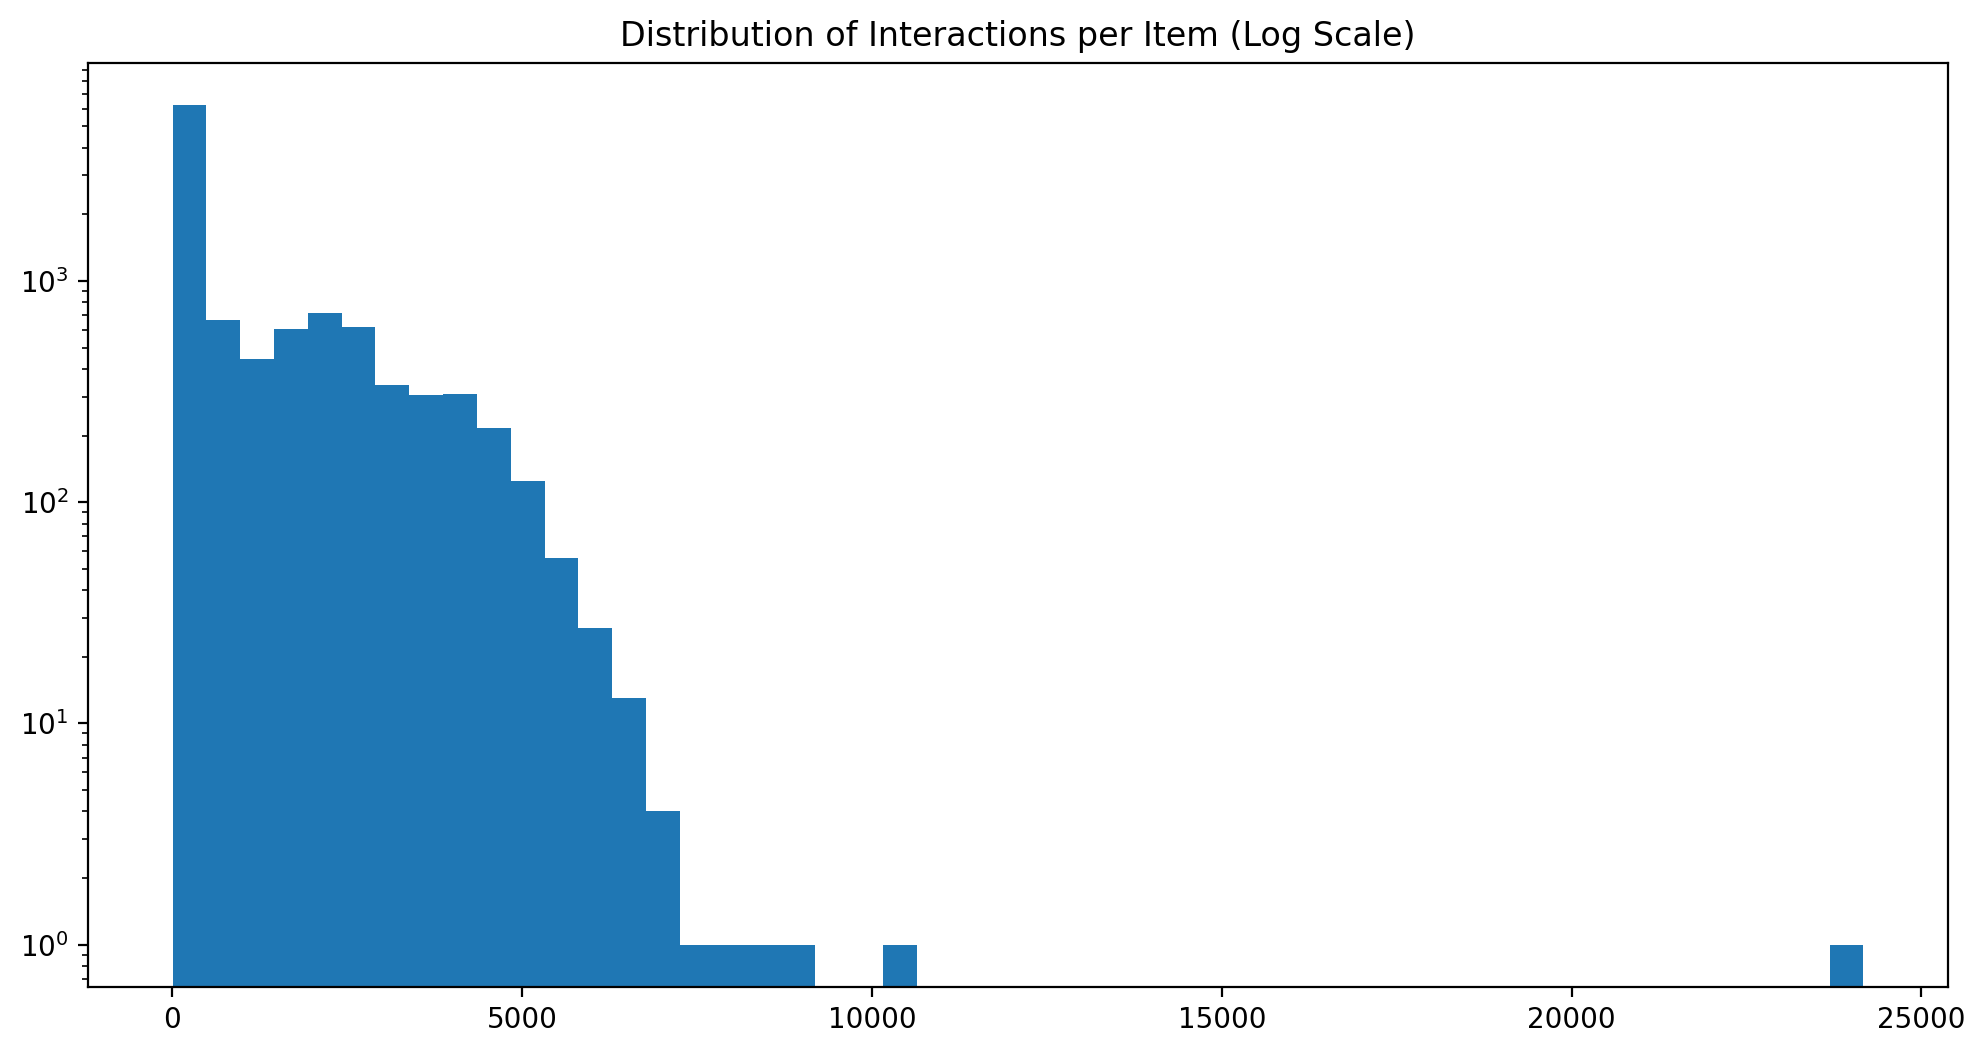

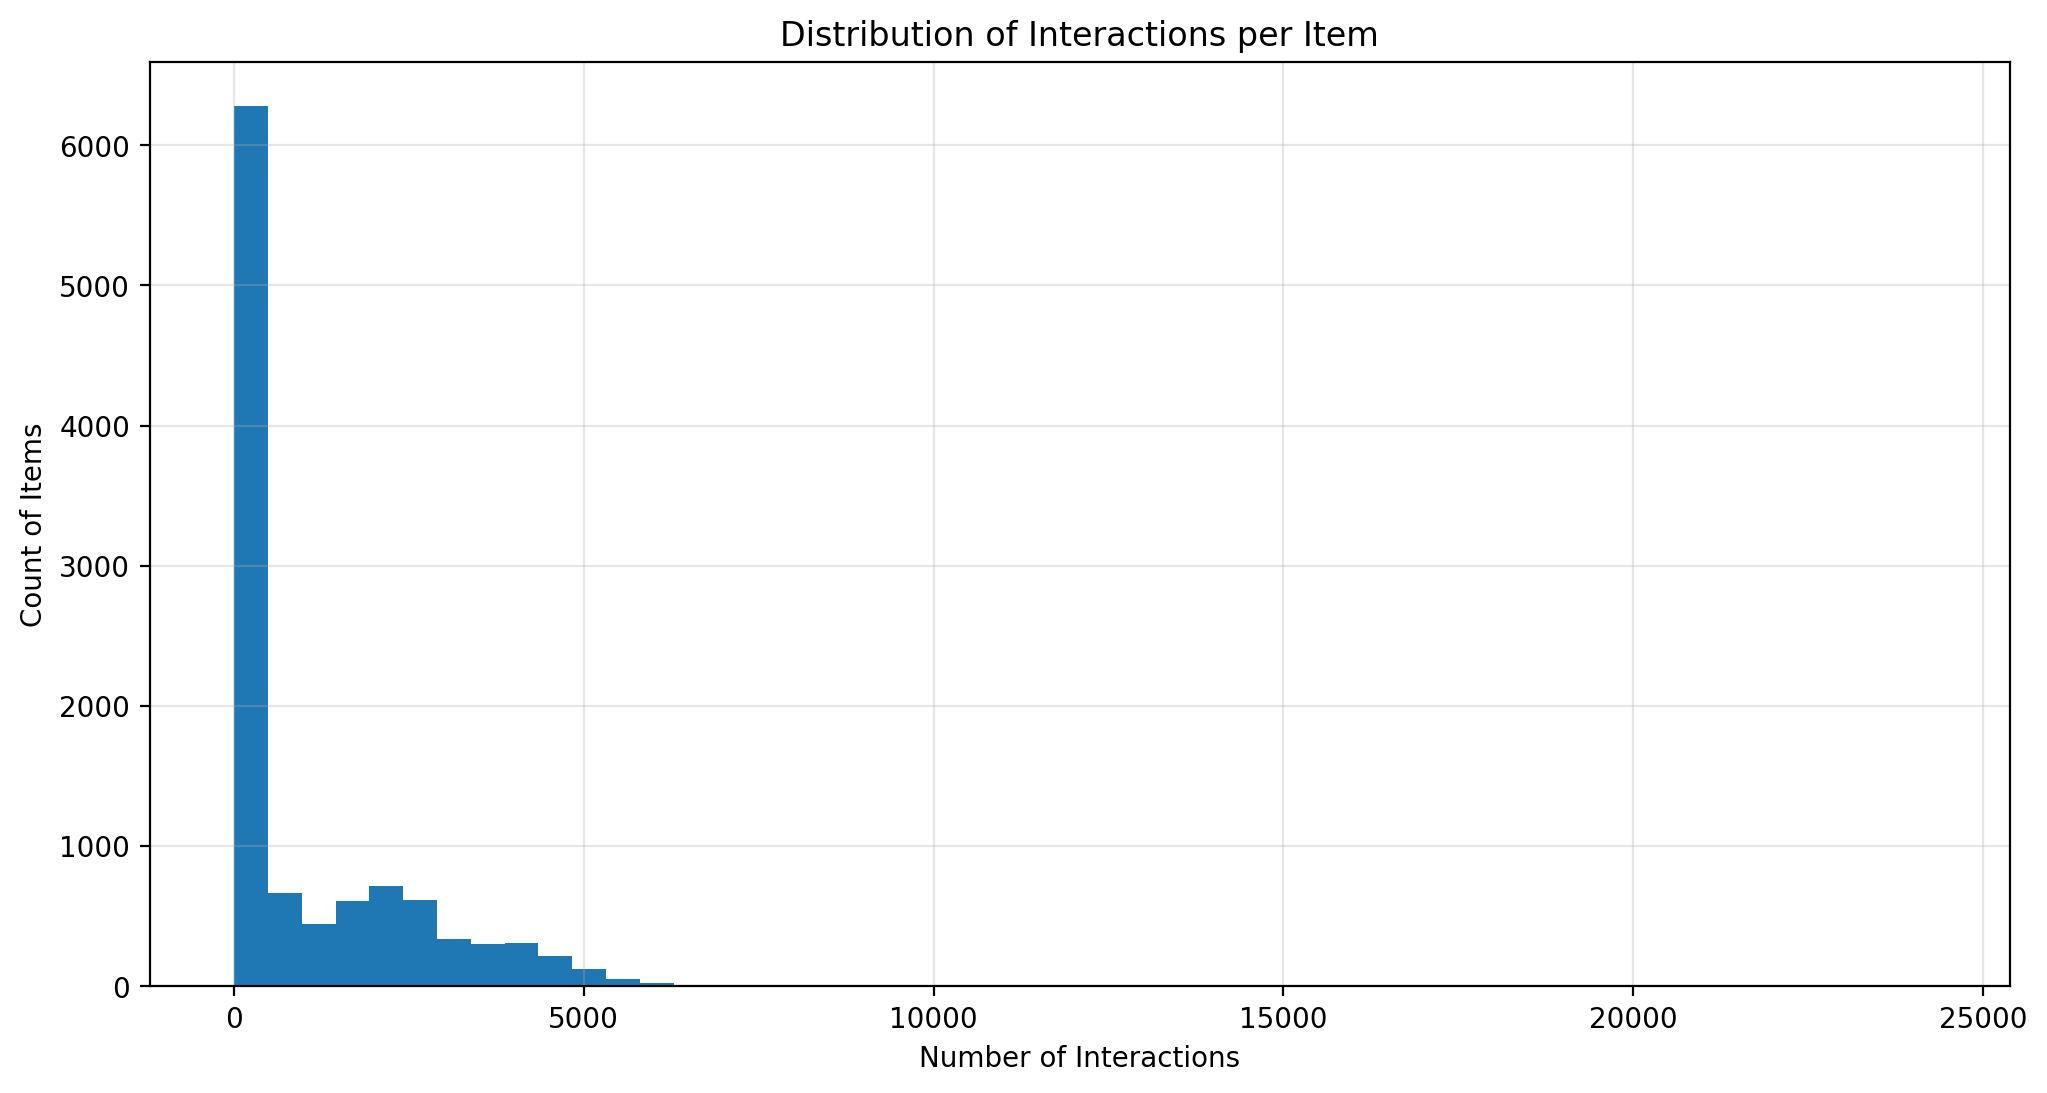

In [6]:
# Let's see the distribution of the interactions per item
item_counts = interactions_train["video_id"].value_counts()

# Plot log histogram of interactions per item
plt.figure(figsize=(12, 6))
plt.hist(item_counts, bins=50, log=True)
plt.title("Distribution of Interactions per Item (Log Scale)")

# Also plot regular scale for comparison
plt.figure(figsize=(12, 6))
plt.hist(item_counts, bins=50)
plt.title("Distribution of Interactions per Item")
plt.xlabel("Number of Interactions")
plt.ylabel("Count of Items")
plt.grid(True, alpha=0.3)
plt.show()

### Temporal Analysis

Let's see the distribution of the interactions over time.

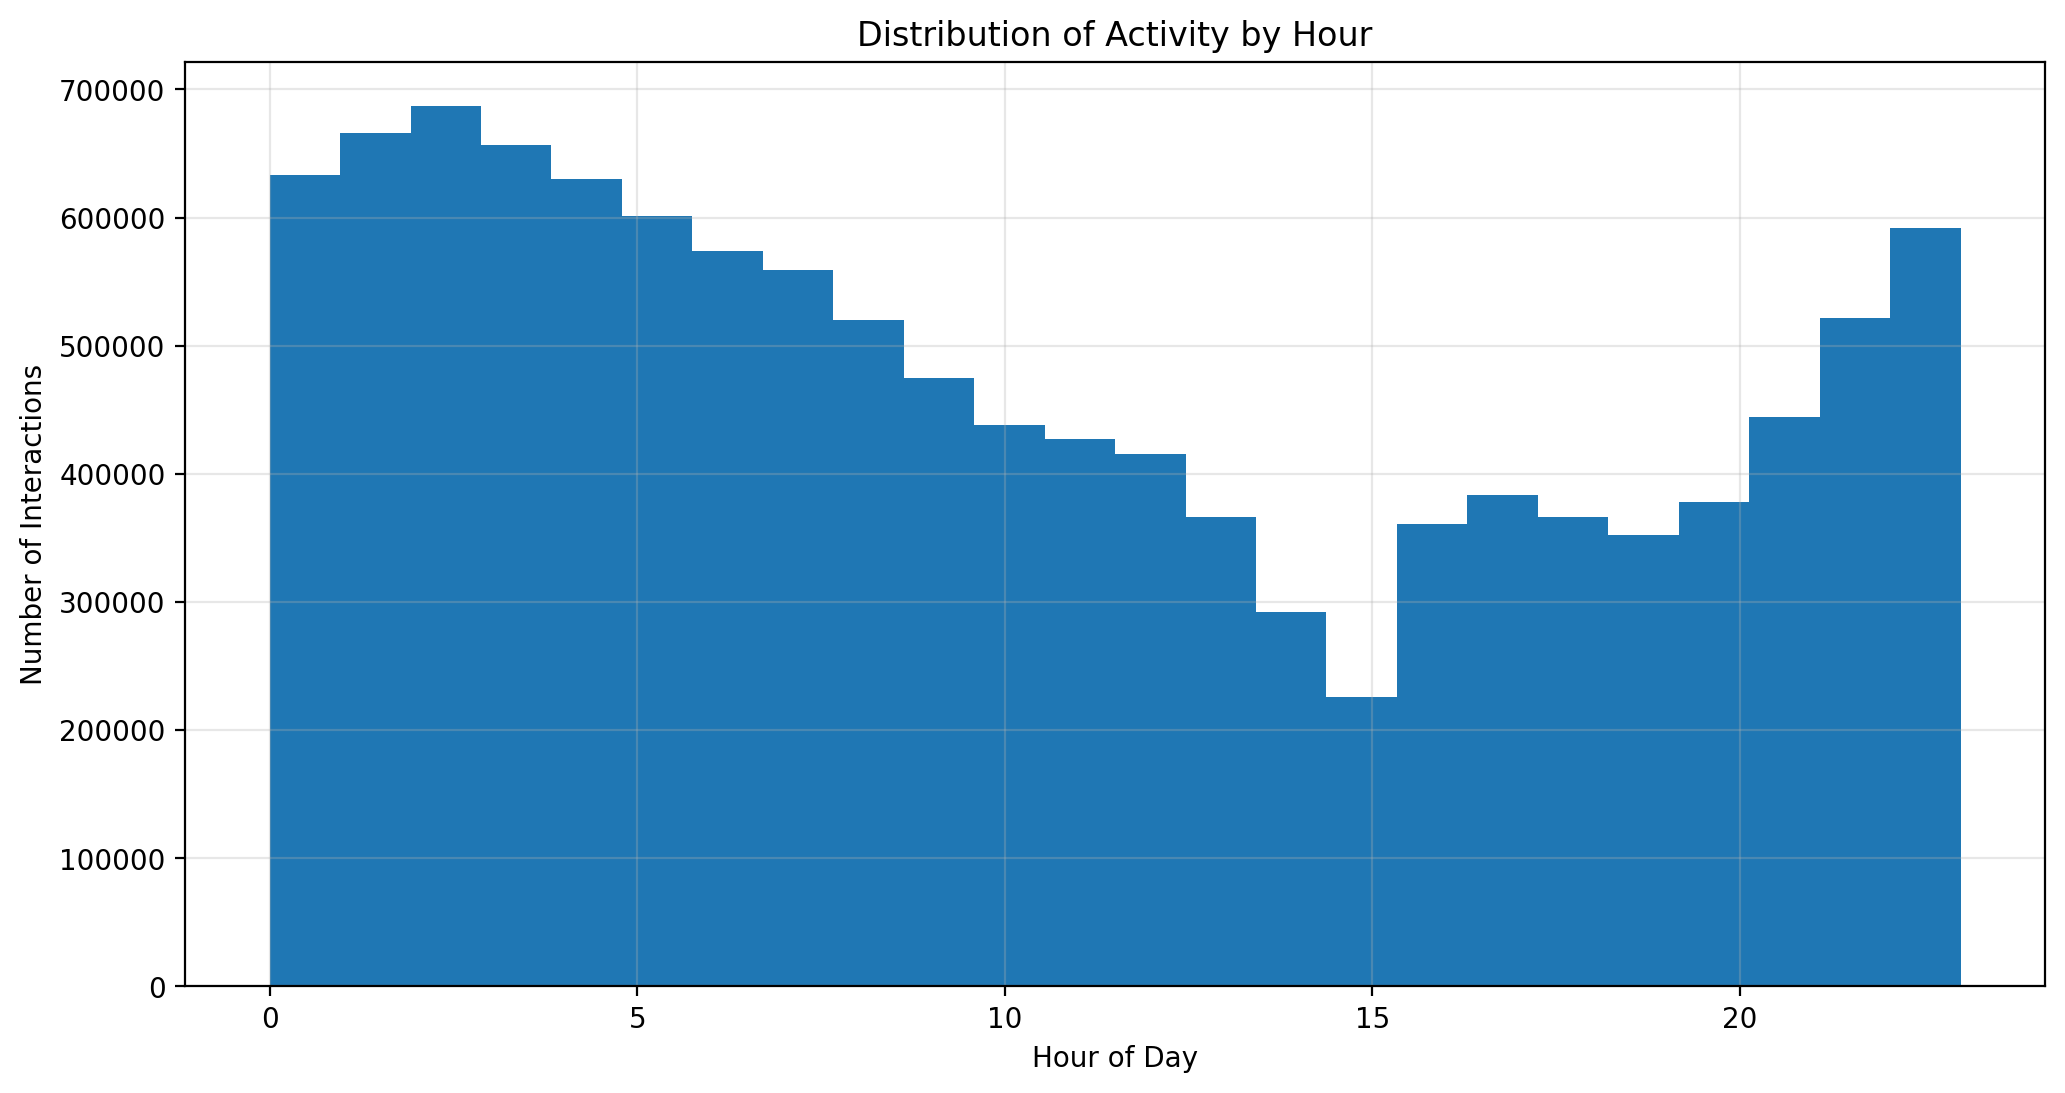

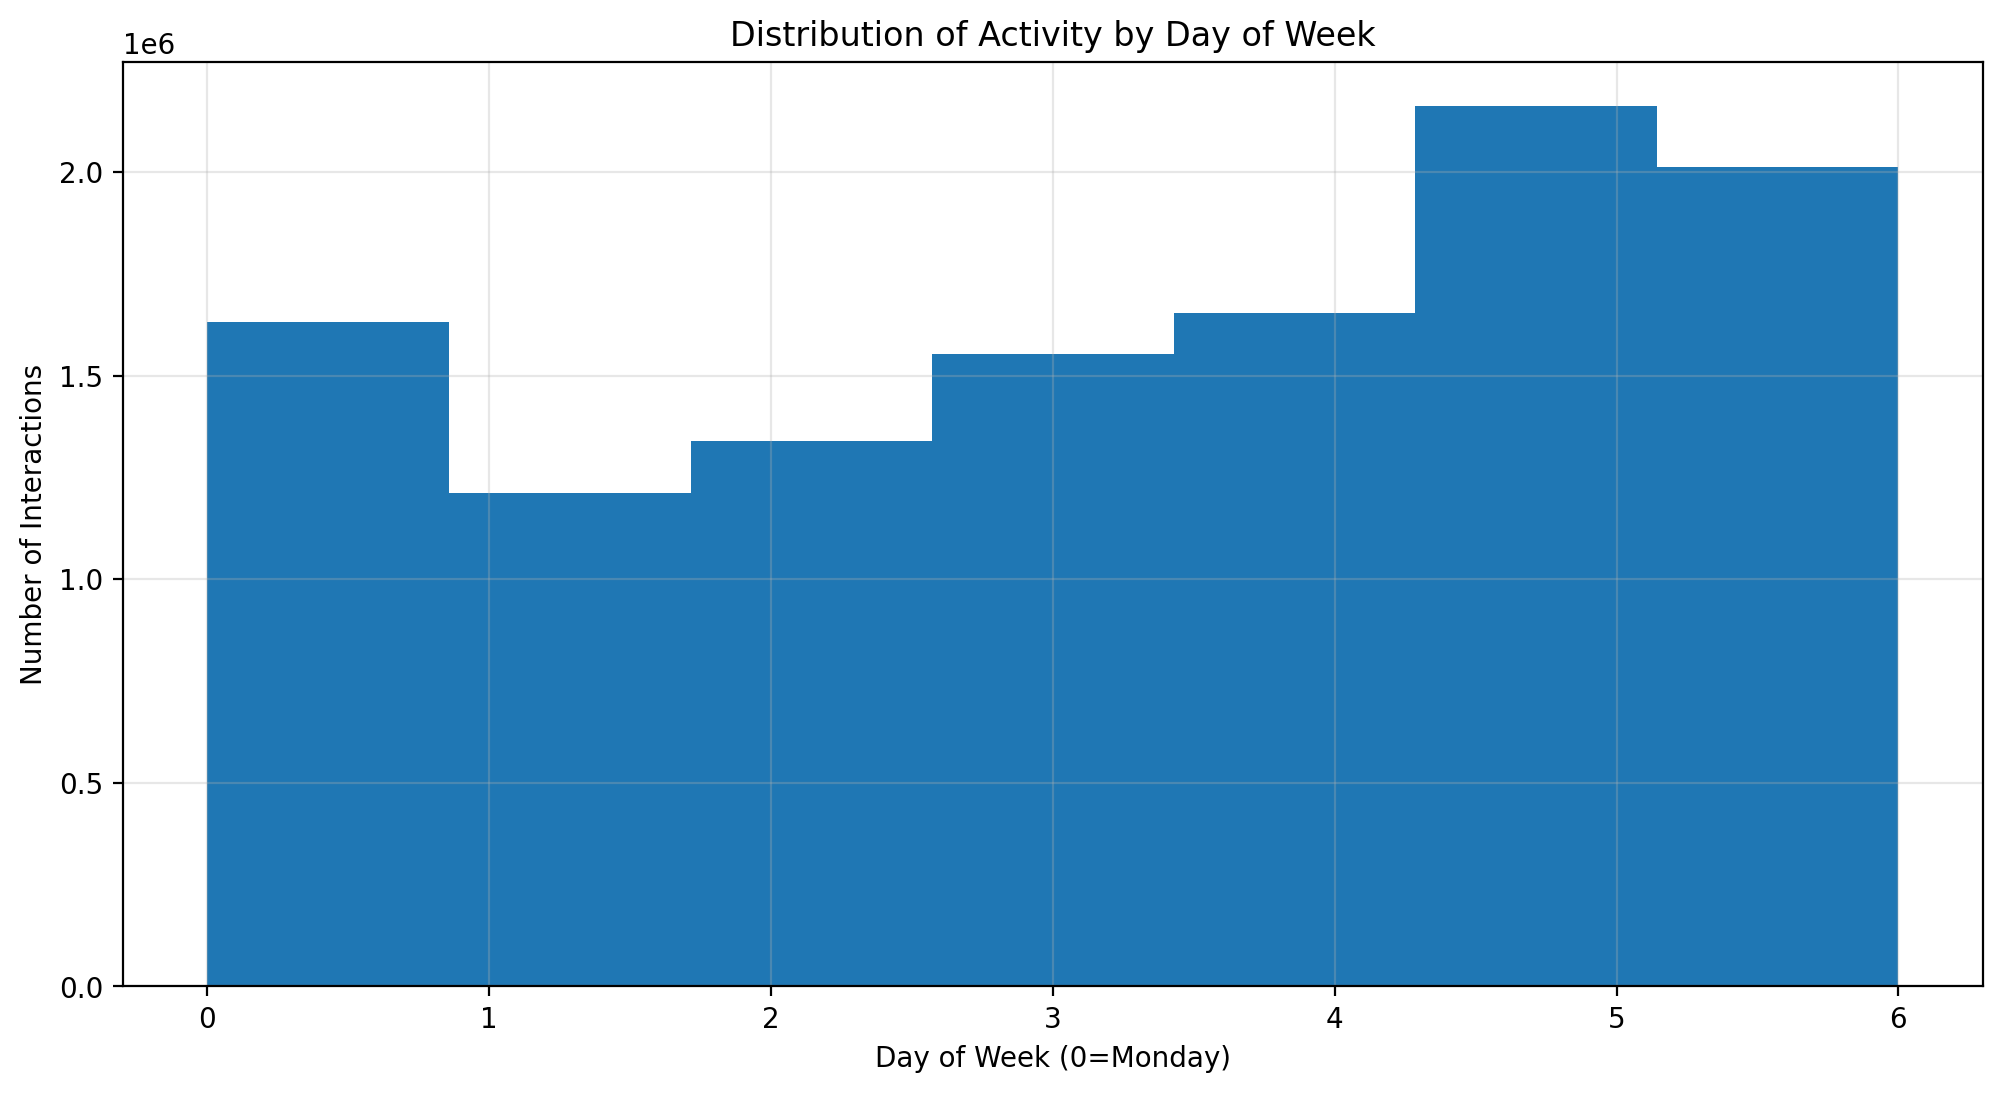

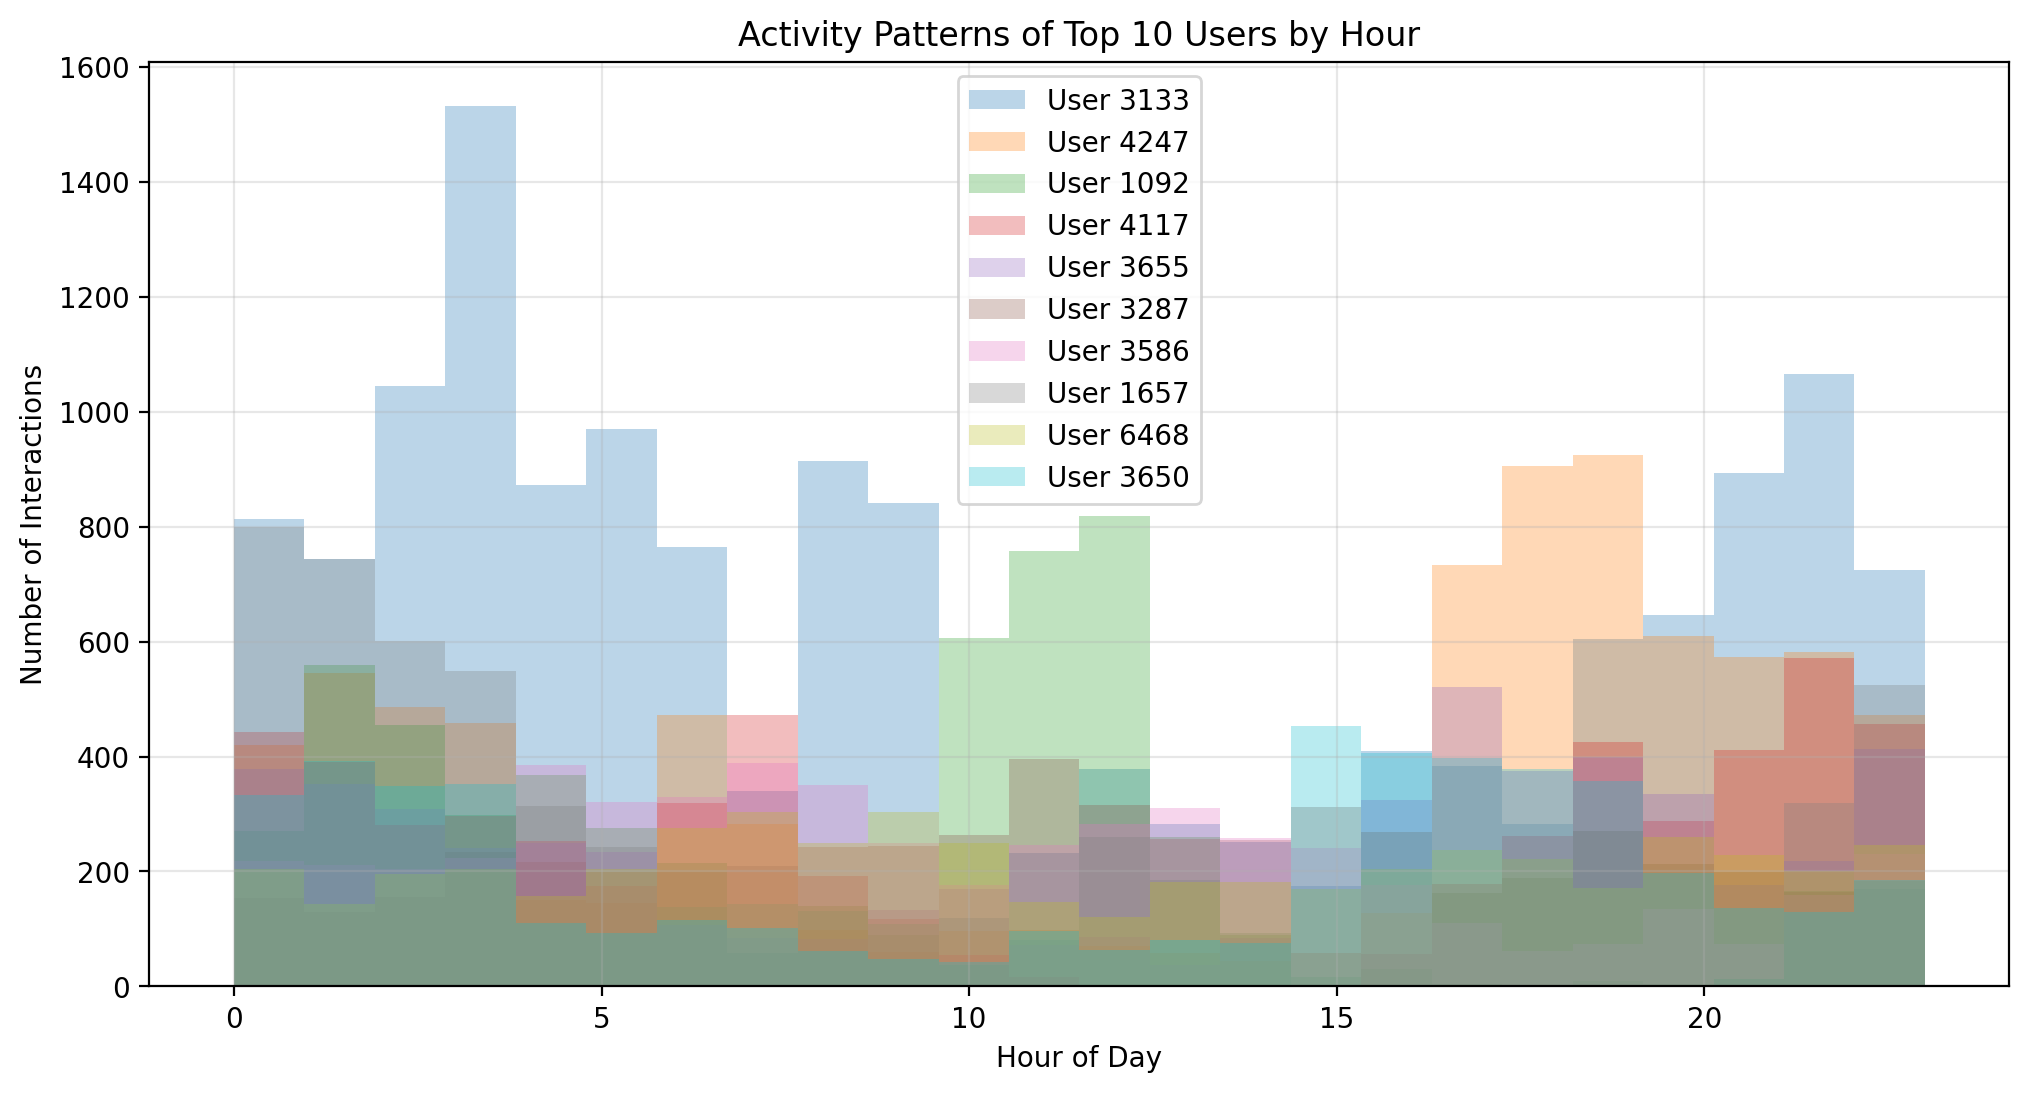


Peak Usage Hours:
Hour 2:00 - 686678 interactions
Hour 1:00 - 666058 interactions
Hour 3:00 - 656852 interactions

Peak Usage Days:
Saturday - 2161139 interactions
Sunday - 2013417 interactions
Friday - 1654813 interactions


In [7]:
# Convert timestamp to datetime
interactions_train["timestamp"] = pd.to_datetime(
    interactions_train["timestamp"].fillna(0), unit="s"
)

interactions_train["hour"] = interactions_train["timestamp"].dt.hour
interactions_train["day"] = interactions_train["timestamp"].dt.dayofweek

# Plot activity over time
plt.figure(figsize=(12, 6))
plt.hist(interactions_train["hour"], bins=24)
plt.title("Distribution of Activity by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Interactions")
plt.grid(True, alpha=0.3)
plt.show()

# Plot activity by day of week
plt.figure(figsize=(12, 6))
plt.hist(interactions_train["day"], bins=7)
plt.title("Distribution of Activity by Day of Week")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Number of Interactions")
plt.grid(True, alpha=0.3)
plt.show()

# Get top 10 most active users
top_users = interactions_train["user_id"].value_counts().head(10).index

# Plot activity patterns for top users
plt.figure(figsize=(12, 6))
for user in top_users:
    user_data = interactions_train[interactions_train["user_id"] == user]
    plt.hist(user_data["hour"], bins=24, alpha=0.3, label=f"User {user}")
plt.title("Activity Patterns of Top 10 Users by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Interactions")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find peak usage times
hourly_activity = interactions_train.groupby("hour").size()
peak_hours = hourly_activity.nlargest(3)

print("\nPeak Usage Hours:")
for hour, count in peak_hours.items():
    print(f"Hour {hour}:00 - {count} interactions")

daily_activity = interactions_train.groupby("day").size()
peak_days = daily_activity.nlargest(3)

print("\nPeak Usage Days:")
for day, count in peak_days.items():
    days = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    print(f"{days[int(day)]} - {count} interactions")

# Training

I chose **ALS** for the model as it is very simple, and doesn't require any feature for the items or the users.

This approch is elegant in the sense that we don't rely on any data other than the time the user has spent on videos, this way, we can be sure we don't introduce bias in the recommendation system by putting too many rules by hand, and lower the risk of user abusing the system by finding the "meta" (the right combination of tags, location and time of day to get the maximum number of views).

In [8]:
# Convert pandas dataframes to spark dataframes
# For some reason, this is by far the slowest part of the notebook
interactions_train_spark = spark.createDataFrame(interactions_train[["user_id", "video_id", "watch_ratio"]])
interactions_test_spark = spark.createDataFrame(interactions_test[["user_id", "video_id", "watch_ratio"]])

interactions_train_spark.show()

+-------+--------+------------------+
|user_id|video_id|       watch_ratio|
+-------+--------+------------------+
|      0|    3649|1.2733965215790926|
|      0|    9598|1.2440823015294975|
|      0|    5262|0.1076125442589782|
|      0|    1963|0.0898852971845672|
|      0|    8234|             0.078|
|      0|    8228| 1.572294776119403|
|      0|    6789|0.1753976030752996|
|      0|    6812| 2.212061894108874|
|      0|     183|0.1304918032786885|
|      0|     169|1.4062659977475171|
|      0|    1988|1.8889678703440431|
|      0|    5274|2.0970967741935485|
|      0|     179|2.1577385857919893|
|      0|    3647|0.0679368262722486|
|      0|    8248|1.2918181818181818|
|      0|     206|0.0902172714238447|
|      0|    6801| 1.935958459541324|
|      0|     171| 33.27602070155262|
|      0|    3672|1.4420652173913044|
|      0|    2000|0.0716965742251223|
+-------+--------+------------------+
only showing top 20 rows



In [ ]:
als = ALS(
    maxIter=5,
    regParam=0.18,
    rank=50,
    userCol="user_id",
    itemCol="video_id",
    ratingCol="watch_ratio",
    coldStartStrategy="drop",
    nonnegative=True,
)

model = als.fit(interactions_train_spark)

## Evaluate model

In [10]:
# Predict on dense matrix
predictions = model.transform(interactions_test_spark)
predictions.show()

+-------+--------+------------------+----------+
|user_id|video_id|       watch_ratio|prediction|
+-------+--------+------------------+----------+
|     19|    1963| 1.551303441084463|  0.979508|
|     19|    8234|0.8389090909090909| 0.7327721|
|     19|     171|1.7607820586543992| 1.4268395|
|     19|    3633|0.9893344133927366| 1.0063632|
|     19|    6775|0.7907789330151695|0.66349685|
|     19|    3630|1.1371578784598733| 1.2494576|
|     19|     175|0.1585329148213441|0.17470832|
|     19|     173|0.4079239483121762|0.42309222|
|     19|     131| 0.670018652177439|0.67842156|
|     19|    5260|0.9532724056603774| 1.1377195|
|     19|     139|0.6697435897435897|0.79098755|
|     19|    1933| 1.033472222222222| 1.1831683|
|     19|    1937|  0.92033856111526|0.96345514|
|     19|    5265|             0.923|0.89394855|
|     19|    6803|1.3159141143037576| 1.1889372|
|     19|    6788|0.5571754904595538| 0.5366102|
|     19|     145|0.6808602150537635| 0.8583628|
|     19|    3647|0.

In [11]:
# Compute some metrics
evaluator_rmse = RegressionEvaluator(
    metricName="rmse", labelCol="watch_ratio", predictionCol="prediction"
)
evaluator_r2 = RegressionEvaluator(
    metricName="r2", labelCol="watch_ratio", predictionCol="prediction"
)
evaluator_var = RegressionEvaluator(
    metricName="var", labelCol="watch_ratio", predictionCol="prediction"
)

rmse  = evaluator_rmse.evaluate(predictions)
r2    = evaluator_r2.evaluate(predictions)
var   = evaluator_var.evaluate(predictions)

print(f"Root mean squared error      = {rmse:.3}")
print(f"Coefficient of determination = {r2:.3}")
print(f"Explained variance           = {var:.3}")

[Stage 140:==================================================>    (12 + 1) / 13]

Root mean squared error      = 1.31
Coefficient of determination = 0.0685
Explained variance           = 0.154


The recommender system is showing promising signs of learning meaningful user-item interactions. The RMSE of 1.31 suggests the model is reasonably consistent at predicting user preferences, considering the inherent variability in watch behavior. The Coefficient of Determination (R²) is at 0.0685, indicating that the model is starting to capture some of the underlying patterns in user engagement. Additionally, the Explained Variance of 0.154 shows that a decent portion of the variability in watch ratios is being accounted for, even in the presence of noisy real-world data.

## Inference

In this part, we recommend videos to users.
Users will be recommended the video they are likely to watch the most (<=> have the maximum predicted `watch_ratio`) and that they have not watched yet

In [12]:
@dataclass
class Recommendation:
    """
    Represents a video the user has not watched yet
    """
    video_id: int
    predicted_watch_ratio: int

def recommend_user(user_id: int, limit = 20) -> List[Recommendation]:
    """
    Returns the `limit` best videos for the user with id `user_id`, sorted
    by how likely the user is to watch it to the end or many times
    """
    users = spark.createDataFrame([
        {"user_id": user_id},
    ])
    recommendations = model.recommendForUserSubset(users, limit).first()['recommendations']
    recommendations = map(lambda rec: Recommendation(rec['video_id'], rec['rating']), recommendations)
    recommendations = list(recommendations)
    return recommendations

In [13]:
recommend_user(42)

[Recommendation(video_id=6598, predicted_watch_ratio=78.64559173583984),
 Recommendation(video_id=5135, predicted_watch_ratio=67.99703979492188),
 Recommendation(video_id=2406, predicted_watch_ratio=64.94096374511719),
 Recommendation(video_id=7445, predicted_watch_ratio=40.81405258178711),
 Recommendation(video_id=2785, predicted_watch_ratio=35.536128997802734),
 Recommendation(video_id=9668, predicted_watch_ratio=26.679109573364258),
 Recommendation(video_id=230, predicted_watch_ratio=25.116893768310547),
 Recommendation(video_id=2767, predicted_watch_ratio=24.73914909362793),
 Recommendation(video_id=4221, predicted_watch_ratio=24.610965728759766),
 Recommendation(video_id=7381, predicted_watch_ratio=22.562101364135742),
 Recommendation(video_id=1594, predicted_watch_ratio=22.129467010498047),
 Recommendation(video_id=2270, predicted_watch_ratio=20.523914337158203),
 Recommendation(video_id=5773, predicted_watch_ratio=19.431428909301758),
 Recommendation(video_id=3605, predicted_wat

The observed watch ratios might seem too high, but they represent only a few cases per user. The `predicted_watch_ratio` should be interpreted as an heuristic instead of the actual time we think the user will spend on a video.

In a real-world scenario, we would probably show the user the videos in the given order and update the model in real time to fine-tune the user's feed as they use the app.